In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import pylab
import wave
import openpyxl
import yaml
import os
import shutil
import _pickle as cpl
import tarfile
import pandas as pd

In [ ]:
# Get all the recordings and separate them by format. 
flac_files = []
wav_files = []
for file in os.listdir("../../dataset/recordings"):
    if file.endswith(".flac"):
        flac_files.append(file)
    elif file.endswith(".wav"):
        wav_files.append(file)

In [ ]:
# Convert all the .flac files to .wav files and store them in 'wav_recordings'
for i in range(len(flac_files)):
    string = 'sox ../recordings/' + str(flac_files[i]) + ' ../wav_recordings/' + str(flac_files[i][:-5]) + '.wav'
    os.system(string)

In [ ]:
# Store the .wav files in 'wav_recordings'
for i in range(len(wav_files)):
    string = 'mv ../' + str(wav_files[i]) + ' ../wav_recordings'
    os.system(string)

In [ ]:
# Loads the validation data
df = pd.ExcelFile('../../dataset/validationsAndROIs.xlsx')
df = df.parse('ROIs')
rs =[]


# Gets the name of all the rcordings
all_wav_files = []
for file in os.listdir("../../dataset/wav_recordings"):
    all_wav_files.append(file[:file.index('.')])

# Extracts the recording_name column and stores it as a list
recording_name = df["recording name"].tolist()

# Formats the string containing the name of the recording to remove everything after the first dot.
for i in range(len(recording_name)):
    recording_name[i] = recording_name[i][:recording_name[i].index('.')]

# If we don't have a recording, then the validation data is not useful by itself. So we want to remove this data. 
for i in range(len(recording_name)):
    if recording_name[i] not in all_wav_files:
        rs.append(recording_name[i])
        recording_name[i] = "delete"

# Creates the column 'recording name' initialized with the corresponding values in tecording_name list, 
# then removes the data labeled as delete

df['recording name'] = recording_name
df = df[df['recording name'] != 'delete']

# Writes out the corrected validation data. 
writer = pd.ExcelWriter('../../dataset/corrected_validationsAndROIs.xlsx')
df.to_excel(writer, 'ROIs', index=False)
writer.save()

# Standarizes the names of all the recording names
for files in os.listdir("../../dataset/wav_recordings"):
    new_name = files[:files.index('.')]
    os.rename("../../dataset/wav_recordings/" + files, "../../dataset/wav_recordings/" + new_name + '.wav')

In [ ]:
grabaciones = list(df['recording name'])

grabaciones

In [ ]:
grabaciones = [grabacion + '.wav' for grabacion in grabaciones]

In [3]:
# Get the Info from the .wav file.
def wavInfo(rec_file):
    wav_file = wave.open(rec_file, 'r')
    frames = wav_file.readframes(-1)
    wave_info = pylab.fromstring(frames, 'Int16') #all .wavs in our dataset are 16bit
    framerate = wav_file.getframerate()
    wav_file.close()
    return wave_info, framerate

# Get the info from the Spectrogram, but don't plot it.
def specInfo(rec_file_list):
    for rec_file in rec_file_list:
        new_file = '../../dataset/spectrograms/' + rec_file + '.png'
        rec_file = '../../dataset/wav_recordings/'+rec_file
        wave_info, framerate = wavInfo(rec_file)
        spectrum, freqs, t, _ = pylab.specgram(wave_info, 
                                               NFFT=512, 
                                               noverlap=256, 
                                               window=pylab.window_hanning, 
                                               Fs=framerate)
        pylab.axis('off')
        pylab.savefig(new_file,
                      bbox_inches='tight', transparent = True)
        pylab.close()
        
        

In [ ]:
spectrum = specInfo(grabaciones)

In [ ]:
yamlData = open('../../dataset/dataset.yaml', 'r')
dataset = yaml.load(yamlData)
yamlData.close()

In [ ]:
dataset

In [4]:
# search for the index of the leftmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def leftmostBinSearch(A, lo, hi, target):
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 >= target):
        if (mid > 0 and A[mid - 1] > target):
            return leftmostBinSearch(A, lo, mid-1, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

# search for the index of the rightmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def rightmostBinSearch(A, lo, hi, target): # something is wrong and it's giving me 1 to the right 
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 <= target):
        if (mid < (len(A) - 1) and A[mid + 1] <= target):
            return rightmostBinSearch(A, mid+1, hi, target)
        else:
            return mid
    elif (A[mid] < target):
        return rightmostBinSearch(A, mid+1, hi, target)
    else:
        return rightmostBinSearch(A, lo, mid-1, target)
    
# Calls on rightmostBinSearch and leftmostBinSearch
def getBounds(A, minVal, maxVal):
    left = leftmostBinSearch(A, 0, len(A)-1, minVal)
    right = rightmostBinSearch(A, 0, len(A)-1, maxVal)
    return left, right

In [41]:
y = []

In [42]:
x = []

In [43]:
def getRawSpecDataset(dataset, path='../../dataset'):
    
    # make directory to store our spec dataset
    dataset_path = path + '/spectrogram_roi_dataset'
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    else:
        shutil.rmtree(dataset_path)
        os.makedirs(dataset_path)
    species = dataset.keys()
    
    # image data to be pickled 
    specs = []
    
    for s in species:
        #s_dir = dataset_path + '/' + s
        s_spec = []
        #os.makedirs(s_dir) # make a directory per species
        
        # load species ROI data
        min_freqs = dataset[s]['min_frequency']
        max_freqs = dataset[s]['max_frequency']
        starts = dataset[s]['start_time']
        ends = dataset[s]['end_time']
        recs = dataset[s]['recording name']
        print(s)
        
        for i in range(0, len(recs)):
            
            rec = '../../dataset/wav_recordings/' + recs[i] # path to ith recording file where s is present
            
            wave_info, framerate = wavInfo(rec)
            spectrum, freqs, times, _ = pylab.specgram(wave_info, 
                                               NFFT=512, 
                                               noverlap=256, 
                                               window=pylab.window_hanning, 
                                               Fs=framerate)
            freqs = np.asarray(freqs)
            #freqs = freqs.flatten(freqs)
            
            x.append(freqs)
            pylab.axis('off')
            pylab.close()
            
            #spectrum, freqs, times = specInfo(rec) # get entire spectrogram data from rec
            
            # get ROI info in rec
            t_0 = starts[i] 
            t_n = ends[i]
            f_0 = min_freqs[i]
            f_n = max_freqs[i]
            
            
            # find closest times and freqs that match ROI info
            t_start, t_end = getBounds(times, t_0, t_n)
            f_start, f_end = getBounds(freqs, f_0, f_n)
            
            '''
            # get modified spectrum, freqs, and times
            #spectrumMod = specMod(spectrum, freqs, times, f_start, f_end, t_start, t_end)
            freqMod = freqs[f_start:f_end]
            timeMod = times[t_start:t_end]
            
            '''
            y.append([t_0, f_0, t_n, f_n])
            
            #np.array([t_start, f_start, t_end, f_end])
            
    #return np.array([t_0, f_0, t_n, f_n])

In [44]:
yamlData = open('../../dataset/dataset.yaml', 'r')
dataset = yaml.load(yamlData)
yamlData.close()


In [45]:
data = getRawSpecDataset(dataset)

Basileuterus bivittatus


/home/kropotkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """


Basileuterus chrysogaster
Chlorothraupis carmioli
Eleutherodactylus brittoni
Eleutherodactylus cochranae
Eleutherodactylus cooki
Eleutherodactylus coqui
Eleutherodactylus juanariveroi
Epinephelus guttatus
Formicarius analis
Hypocnemis subflava
Liosceles thoracicus
Megascops guatemalae
Megascops nudipes
Microcerculus marginatus
Myrmeciza hemimelaena
Myrmoborus leucophrys
Percnostola lophotes
Saltator grossus
Thamnophilus schistaceus
Unknown Insect


In [46]:
y[0]

[40.7895215572, 1805.81896552, 43.1253410951, 5341.42241379]

In [47]:
x[0]

array([     0.       ,     86.1328125,    172.265625 ,    258.3984375,
          344.53125  ,    430.6640625,    516.796875 ,    602.9296875,
          689.0625   ,    775.1953125,    861.328125 ,    947.4609375,
         1033.59375  ,   1119.7265625,   1205.859375 ,   1291.9921875,
         1378.125    ,   1464.2578125,   1550.390625 ,   1636.5234375,
         1722.65625  ,   1808.7890625,   1894.921875 ,   1981.0546875,
         2067.1875   ,   2153.3203125,   2239.453125 ,   2325.5859375,
         2411.71875  ,   2497.8515625,   2583.984375 ,   2670.1171875,
         2756.25     ,   2842.3828125,   2928.515625 ,   3014.6484375,
         3100.78125  ,   3186.9140625,   3273.046875 ,   3359.1796875,
         3445.3125   ,   3531.4453125,   3617.578125 ,   3703.7109375,
         3789.84375  ,   3875.9765625,   3962.109375 ,   4048.2421875,
         4134.375    ,   4220.5078125,   4306.640625 ,   4392.7734375,
         4478.90625  ,   4565.0390625,   4651.171875 ,   4737.3046875,
      

In [48]:
images = np.asarray(x)
bbox = np.asarray(y)

In [51]:
X = images
y = bbox

In [56]:
X.shape

(240, 257)

In [52]:
# Split training and test.
i = int(0.8 * len(X))
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = images[i:]
test_bboxes = bbox[i:]

In [59]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(4096, input_dim=X.shape[-1]),
        Dense(4096),
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [60]:
# Train.
model.fit(train_X, train_y, nb_epoch=30, validation_data=(test_X, test_y), verbose=2)

/home/kropotkin/anaconda3/lib/python3.6/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 192 samples, validate on 48 samples
Epoch 1/30
 - 3s - loss: 1764502616.6667 - val_loss: 19224352.0000
Epoch 2/30
 - 3s - loss: 12790411.1667 - val_loss: 34946408.0000
Epoch 3/30
 - 3s - loss: 12695190.7917 - val_loss: 8235044.6667
Epoch 4/30
 - 3s - loss: 4950216.2500 - val_loss: 7775362.5000
Epoch 5/30
 - 3s - loss: 3889949.5000 - val_loss: 8787627.3333
Epoch 6/30
 - 3s - loss: 8262604.1667 - val_loss: 12646638.6667
Epoch 7/30
 - 3s - loss: 7614734.5000 - val_loss: 7559218.5000
Epoch 8/30
 - 3s - loss: 3676175.0000 - val_loss: 7868400.8333
Epoch 9/30
 - 3s - loss: 4356695.6667 - val_loss: 11133848.0000
Epoch 10/30
 - 3s - loss: 9478985.9167 - val_loss: 24356770.6667
Epoch 11/30
 - 3s - loss: 12959377.8333 - val_loss: 9957160.6667
Epoch 12/30
 - 3s - loss: 6094464.1667 - val_loss: 9064915.3333
Epoch 13/30
 - 3s - loss: 8625937.0833 - val_loss: 20840020.0000
Epoch 14/30
 - 3s - loss: 17484401.5000 - val_loss: 36093461.3333
Epoch 15/30
 - 3s - loss: 26416995.6667 - val_loss: 20

In [71]:
num_objects = 1
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(48, 1, 4)

In [72]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [73]:
pred_bboxes

array([[[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-688789.4375  ,  813961.375   ,  -18862.109375,  959830.1875  ]],

       [[-68

TypeError: Invalid dimensions for image data

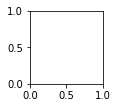

In [69]:
img_size = 257
# Show a few images and predicted bounding boxes from the test dataset. 
#plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)